In [1]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

c:\Users\savithadevi\.conda\envs\pDL\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PyTorch Version:  1.11.0
Torchvision Version:  0.12.0


In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
def my_lam(x):
    if x.size(0)==1:
        x.repeat(3,1,1)
    return x

trans = transforms.Lambda(my_lam)
data_transforms = {
    'train': transforms.Compose([
        
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        # transforms.Resize(224)
        # transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([

        transforms.Grayscale(num_output_channels=3),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'fer_data\pics'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

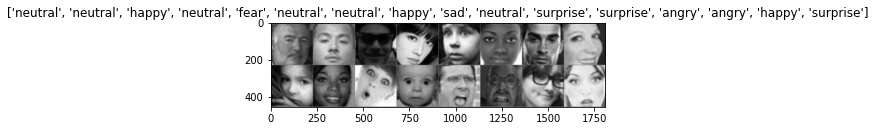

In [3]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [8]:
inputs[0].shape

torch.Size([3, 224, 224])

In [4]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [5]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## ResNet-18

In [11]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 7)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [12]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 1.2755 Acc: 0.5154
val Loss: 1.0878 Acc: 0.5910

Epoch 1/24
----------
train Loss: 1.0221 Acc: 0.6204
val Loss: 1.0529 Acc: 0.6177

Epoch 2/24
----------
train Loss: 0.9182 Acc: 0.6631
val Loss: 0.9891 Acc: 0.6347

Epoch 3/24
----------
train Loss: 0.8164 Acc: 0.6984
val Loss: 0.9715 Acc: 0.6531

Epoch 4/24
----------
train Loss: 0.7237 Acc: 0.7368
val Loss: 1.0131 Acc: 0.6542

Epoch 5/24
----------
train Loss: 0.6366 Acc: 0.7678
val Loss: 1.0433 Acc: 0.6584

Epoch 6/24
----------
train Loss: 0.5516 Acc: 0.8010
val Loss: 1.0804 Acc: 0.6500

Epoch 7/24
----------
train Loss: 0.3481 Acc: 0.8869
val Loss: 1.0196 Acc: 0.6743

Epoch 8/24
----------
train Loss: 0.2721 Acc: 0.9173
val Loss: 1.0644 Acc: 0.6790

Epoch 9/24
----------
train Loss: 0.2351 Acc: 0.9256
val Loss: 1.0970 Acc: 0.6787

Epoch 10/24
----------
train Loss: 0.2062 Acc: 0.9378
val Loss: 1.1486 Acc: 0.6748

Epoch 11/24
----------
train Loss: 0.1795 Acc: 0.9463
val Loss: 1.1686 Acc: 0.6757

Ep

In [13]:
nb_classes = 7

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['val']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)

tensor([[308.,   7.,  34.,  17.,  27.,  64.,  10.],
        [ 13.,  30.,   6.,   0.,   0.,   7.,   0.],
        [ 57.,   1., 232.,  18.,  37., 118.,  33.],
        [ 18.,   2.,  14., 790.,  37.,  18.,  16.],
        [ 55.,   0.,  34.,  62., 344., 106.,   6.],
        [ 82.,   3.,  66.,  27.,  66., 398.,  11.],
        [ 12.,   0.,  24.,  18.,  10.,   7., 344.]])


In [14]:
print(confusion_matrix.diag()/confusion_matrix.sum(1))

tensor([0.6595, 0.5357, 0.4677, 0.8827, 0.5667, 0.6095, 0.8289])


In [15]:
confusion_matrix.sum(1)

tensor([467.,  56., 496., 895., 607., 653., 415.])

In [16]:
def plot_confusion_matrix(
    confusion_matrix,
    classes,
    normalize=False,
    title="Confusion matrix",
    cmap=plt.cm.Blues,
    ylabel="True label",
    xlabel="Predicted label",
    filename=None,
):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=2, suppress=True)

    if normalize:
        normalisation_factor = confusion_matrix.sum(axis=1)[:, np.newaxis] + np.finfo(float).eps
        confusion_matrix = confusion_matrix.astype("float") / normalisation_factor

    plt.imshow(confusion_matrix, interpolation="nearest", cmap=cmap, vmin=0, vmax=1)
    plt.title(title, fontsize=20)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)

    fmt = ".2f" if normalize else "d"
    threshold = confusion_matrix.max() / 2.0
    for i, j in itertools.product(range(confusion_matrix.shape[0]), range(confusion_matrix.shape[1])):
        plt.text(
            j,
            i,
            format(confusion_matrix[i, j], fmt),
            horizontalalignment="center",
            color="white" if confusion_matrix[i, j] > threshold else "black",
            fontsize=12,
        )

    plt.tight_layout()
    plt.ylabel(ylabel, fontsize=20)
    plt.xlabel(xlabel, fontsize=20)

In [23]:
confusion_matrix = confusion_matrix.numpy()

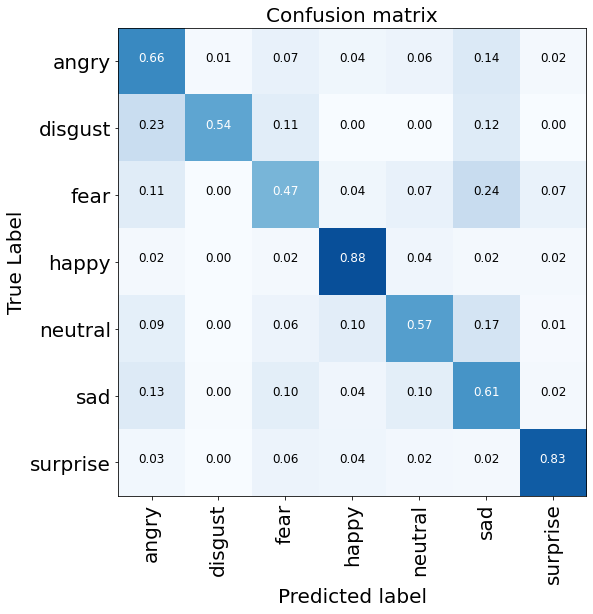

In [27]:
import itertools
fig = plt.figure(figsize=(15, 15))

plt.subplot(1, 2, 1)
confusion_matrix_gbm = confusion_matrix
plot_confusion_matrix(
    confusion_matrix_gbm,
    classes=[name for idx, name in enumerate(class_names)],
    normalize=True,
    ylabel="True Label",
    xlabel="Predicted label",
    title="Confusion matrix")

# plt.subplot(1, 2, 2)
# confusion_matrix_gbm = metrics.confusion_matrix(predictions, true_labels)
# plot_confusion_matrix(
#     confusion_matrix_gbm,
#     classes=[name for idx, name in enumerate(class_names) if idx in class_labels],
#     normalize=True,
#     xlabel="Truth (LAND COVER)",
#     ylabel="Predicted (GBM)",
#     title="Transposed Confusion matrix",


plt.tight_layout()

## ResNet-34

In [29]:
model_ft = models.resnet34(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 7)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [30]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 1.2540 Acc: 0.5274
val Loss: 1.0503 Acc: 0.6057

Epoch 1/24
----------
train Loss: 0.9925 Acc: 0.6297
val Loss: 0.9857 Acc: 0.6395

Epoch 2/24
----------
train Loss: 0.8666 Acc: 0.6812
val Loss: 0.9626 Acc: 0.6556

Epoch 3/24
----------
train Loss: 0.7708 Acc: 0.7146
val Loss: 0.9513 Acc: 0.6578

Epoch 4/24
----------
train Loss: 0.6913 Acc: 0.7490
val Loss: 1.0034 Acc: 0.6551

Epoch 5/24
----------
train Loss: 0.6073 Acc: 0.7792
val Loss: 1.0025 Acc: 0.6612

Epoch 6/24
----------
train Loss: 0.5339 Acc: 0.8086
val Loss: 1.0553 Acc: 0.6573

Epoch 7/24
----------
train Loss: 0.3222 Acc: 0.8937
val Loss: 1.0427 Acc: 0.6868

Epoch 8/24
----------
train Loss: 0.2380 Acc: 0.9226
val Loss: 1.1017 Acc: 0.6799

Epoch 9/24
----------
train Loss: 0.1996 Acc: 0.9359
val Loss: 1.1255 Acc: 0.6815

Epoch 10/24
----------
train Loss: 0.1693 Acc: 0.9476
val Loss: 1.1857 Acc: 0.6818

Epoch 11/24
----------
train Loss: 0.1496 Acc: 0.9535
val Loss: 1.2309 Acc: 0.6846

Ep

In [32]:
nb_classes = 7

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['val']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)

tensor([[289.,   7.,  51.,  26.,  33.,  56.,   5.],
        [ 14.,  32.,   2.,   1.,   0.,   7.,   0.],
        [ 46.,   2., 251.,  14.,  55.,  92.,  36.],
        [ 13.,   0.,   7., 793.,  52.,  16.,  14.],
        [ 35.,   0.,  25.,  48., 401.,  92.,   6.],
        [ 62.,   1.,  78.,  32.,  99., 369.,  12.],
        [ 10.,   0.,  37.,  16.,  10.,  11., 331.]])


In [34]:
confusion_matrix = confusion_matrix.numpy()

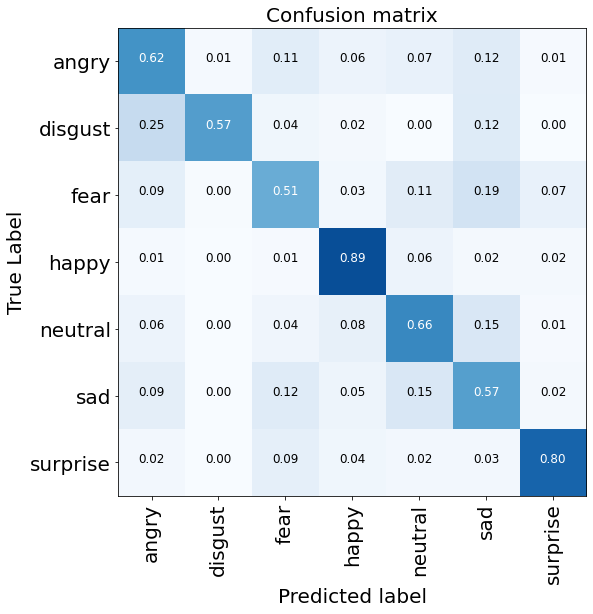

In [35]:
import itertools
fig = plt.figure(figsize=(15, 15))

plt.subplot(1, 2, 1)
confusion_matrix_gbm = confusion_matrix
plot_confusion_matrix(
    confusion_matrix_gbm,
    classes=[name for idx, name in enumerate(class_names)],
    normalize=True,
    ylabel="True Label",
    xlabel="Predicted label",
    title="Confusion matrix")

# plt.subplot(1, 2, 2)
# confusion_matrix_gbm = metrics.confusion_matrix(predictions, true_labels)
# plot_confusion_matrix(
#     confusion_matrix_gbm,
#     classes=[name for idx, name in enumerate(class_names) if idx in class_labels],
#     normalize=True,
#     xlabel="Truth (LAND COVER)",
#     ylabel="Predicted (GBM)",
#     title="Transposed Confusion matrix",


plt.tight_layout()

## VGG-16

In [53]:
model_ft = models.vgg16(pretrained=True)
num_ftrs = model_ft.classifier[6].in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.classifier[6] = nn.Linear(num_ftrs, 7, bias=True)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [54]:
model_ft

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [57]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------
train Loss: 1.0807 Acc: 0.5911
val Loss: 1.0484 Acc: 0.6016

Epoch 1/9
----------
train Loss: 0.9856 Acc: 0.6340
val Loss: 1.0117 Acc: 0.6186

Epoch 2/9
----------
train Loss: 0.9116 Acc: 0.6575
val Loss: 1.0042 Acc: 0.6199

Epoch 3/9
----------
train Loss: 0.8439 Acc: 0.6826
val Loss: 0.9565 Acc: 0.6478

Epoch 4/9
----------
train Loss: 0.7798 Acc: 0.7104
val Loss: 0.9805 Acc: 0.6422

Epoch 5/9
----------
train Loss: 0.7138 Acc: 0.7382
val Loss: 0.9801 Acc: 0.6442

Epoch 6/9
----------
train Loss: 0.5111 Acc: 0.8164
val Loss: 0.9841 Acc: 0.6679

Epoch 7/9
----------
train Loss: 0.4549 Acc: 0.8359
val Loss: 0.9960 Acc: 0.6748

Epoch 8/9
----------
train Loss: 0.4206 Acc: 0.8490
val Loss: 1.0327 Acc: 0.6718

Epoch 9/9
----------
train Loss: 0.3787 Acc: 0.8665
val Loss: 1.0712 Acc: 0.6682

Training complete in 60m 49s
Best val Acc: 0.674840


In [58]:
nb_classes = 7

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['val']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)
confusion_matrix = confusion_matrix.numpy()

tensor([[279.,   7.,  56.,  18.,  38.,  61.,   8.],
        [ 17.,  28.,   3.,   2.,   1.,   4.,   1.],
        [ 43.,   6., 224.,  22.,  54., 103.,  44.],
        [ 16.,   0.,  15., 778.,  52.,  19.,  15.],
        [ 34.,   3.,  29.,  43., 396.,  97.,   5.],
        [ 65.,   6.,  68.,  19., 103., 383.,   9.],
        [ 13.,   0.,  36.,  16.,   9.,   7., 334.]])


In [59]:
confusion_matrix = confusion_matrix.numpy()

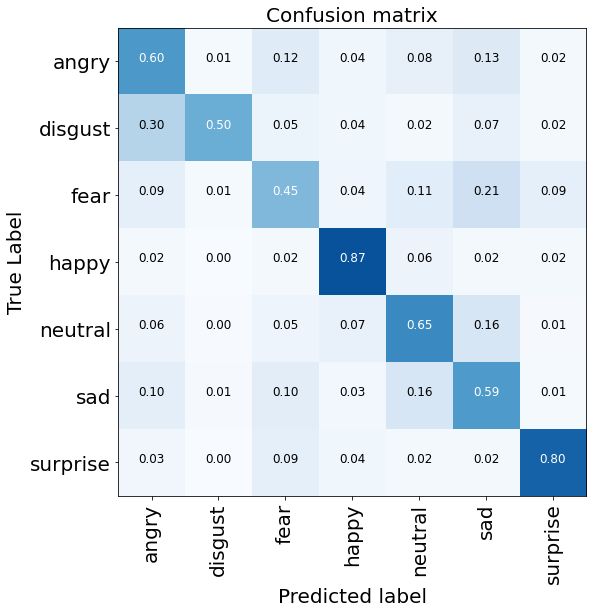

In [60]:
import itertools
fig = plt.figure(figsize=(15, 15))

plt.subplot(1, 2, 1)
confusion_matrix_gbm = confusion_matrix
plot_confusion_matrix(
    confusion_matrix_gbm,
    classes=[name for idx, name in enumerate(class_names)],
    normalize=True,
    ylabel="True Label",
    xlabel="Predicted label",
    title="Confusion matrix")

# plt.subplot(1, 2, 2)
# confusion_matrix_gbm = metrics.confusion_matrix(predictions, true_labels)
# plot_confusion_matrix(
#     confusion_matrix_gbm,
#     classes=[name for idx, name in enumerate(class_names) if idx in class_labels],
#     normalize=True,
#     xlabel="Truth (LAND COVER)",
#     ylabel="Predicted (GBM)",
#     title="Transposed Confusion matrix",


plt.tight_layout()

## Squeeze_net

In [72]:
model_ft = models.squeezenet1_1(pretrained=True)
num_ftrs = model_ft.classifier[1].in_channels
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.classifier[1] = nn.Conv2d(num_ftrs, 7, kernel_size=(1,1), stride=(1,1))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [74]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


c:\Users\savithadevi\.conda\envs\pDL\lib\site-packages\torch\nn\functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


train Loss: 1.5037 Acc: 0.4145
val Loss: 1.3620 Acc: 0.4870

Epoch 1/24
----------
train Loss: 1.2503 Acc: 0.5301
val Loss: 1.2929 Acc: 0.5032

Epoch 2/24
----------
train Loss: 1.1609 Acc: 0.5619
val Loss: 1.1565 Acc: 0.5606

Epoch 3/24
----------
train Loss: 1.1060 Acc: 0.5843
val Loss: 1.1317 Acc: 0.5740

Epoch 4/24
----------
train Loss: 1.0621 Acc: 0.6028
val Loss: 1.0620 Acc: 0.6035

Epoch 5/24
----------
train Loss: 1.0304 Acc: 0.6147
val Loss: 1.0731 Acc: 0.5963

Epoch 6/24
----------
train Loss: 1.0001 Acc: 0.6247
val Loss: 1.0832 Acc: 0.5940

Epoch 7/24
----------
train Loss: 0.9000 Acc: 0.6636
val Loss: 0.9994 Acc: 0.6264

Epoch 8/24
----------
train Loss: 0.8788 Acc: 0.6736
val Loss: 0.9954 Acc: 0.6344

Epoch 9/24
----------
train Loss: 0.8677 Acc: 0.6770
val Loss: 0.9957 Acc: 0.6317

Epoch 10/24
----------
train Loss: 0.8603 Acc: 0.6814
val Loss: 1.0019 Acc: 0.6356

Epoch 11/24
----------
train Loss: 0.8538 Acc: 0.6832
val Loss: 0.9927 Acc: 0.6303

Epoch 12/24
----------
t

In [75]:
nb_classes = 7

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['val']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)
confusion_matrix = confusion_matrix.numpy()

tensor([[252.,   5.,  44.,  22.,  58.,  74.,  12.],
        [ 19.,  13.,   8.,   1.,   3.,  11.,   1.],
        [ 49.,   2., 180.,  12.,  79., 120.,  54.],
        [ 17.,   0.,  17., 749.,  74.,  16.,  22.],
        [ 35.,   2.,  31.,  44., 394.,  93.,   8.],
        [ 61.,   2.,  63.,  29., 120., 367.,  11.],
        [ 10.,   0.,  34.,  17.,  12.,   9., 333.]])


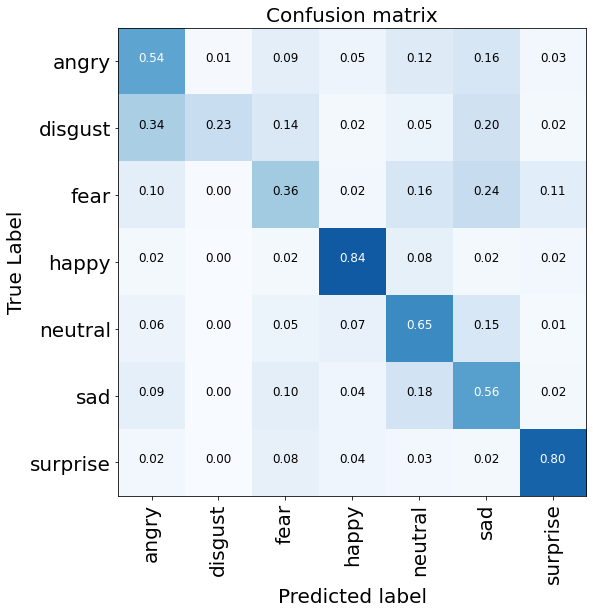

In [76]:
import itertools
fig = plt.figure(figsize=(15, 15))

plt.subplot(1, 2, 1)
confusion_matrix_gbm = confusion_matrix
plot_confusion_matrix(
    confusion_matrix_gbm,
    classes=[name for idx, name in enumerate(class_names)],
    normalize=True,
    ylabel="True Label",
    xlabel="Predicted label",
    title="Confusion matrix")

# plt.subplot(1, 2, 2)
# confusion_matrix_gbm = metrics.confusion_matrix(predictions, true_labels)
# plot_confusion_matrix(
#     confusion_matrix_gbm,
#     classes=[name for idx, name in enumerate(class_names) if idx in class_labels],
#     normalize=True,
#     xlabel="Truth (LAND COVER)",
#     ylabel="Predicted (GBM)",
#     title="Transposed Confusion matrix",


plt.tight_layout()

## Densenet-121

In [83]:
model_ft = models.densenet121(pretrained=True)
num_ftrs = model_ft.classifier.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.classifier = nn.Linear(num_ftrs, 7)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [86]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=5)

Epoch 0/4
----------
train Loss: 0.1721 Acc: 0.9515
val Loss: 1.1066 Acc: 0.6888

Epoch 1/4
----------
train Loss: 0.1641 Acc: 0.9532
val Loss: 1.1023 Acc: 0.6871

Epoch 2/4
----------
train Loss: 0.1636 Acc: 0.9543
val Loss: 1.1147 Acc: 0.6899

Epoch 3/4
----------
train Loss: 0.1580 Acc: 0.9552
val Loss: 1.1160 Acc: 0.6863

Epoch 4/4
----------
train Loss: 0.1587 Acc: 0.9555
val Loss: 1.1166 Acc: 0.6771

Training complete in 22m 28s
Best val Acc: 0.689886


In [87]:
nb_classes = 7

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['val']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)
confusion_matrix = confusion_matrix.numpy()

tensor([[285.,   6.,  45.,  23.,  38.,  59.,  11.],
        [ 10.,  39.,   1.,   1.,   0.,   4.,   1.],
        [ 53.,   0., 255.,  21.,  57.,  77.,  33.],
        [ 11.,   1.,   5., 804.,  49.,  10.,  15.],
        [ 40.,   1.,  26.,  59., 398.,  76.,   7.],
        [ 73.,   2.,  69.,  43., 103., 351.,  12.],
        [ 12.,   0.,  26.,  18.,  11.,   4., 344.]])


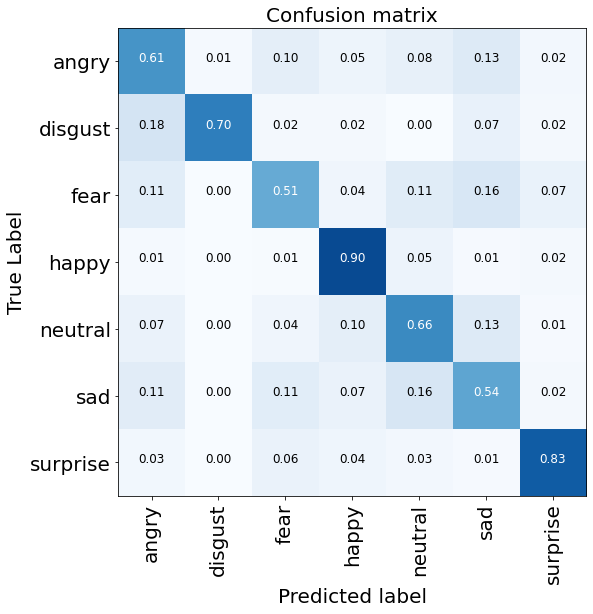

In [88]:
import itertools
fig = plt.figure(figsize=(15, 15))

plt.subplot(1, 2, 1)
confusion_matrix_gbm = confusion_matrix
plot_confusion_matrix(
    confusion_matrix_gbm,
    classes=[name for idx, name in enumerate(class_names)],
    normalize=True,
    ylabel="True Label",
    xlabel="Predicted label",
    title="Confusion matrix")

# plt.subplot(1, 2, 2)
# confusion_matrix_gbm = metrics.confusion_matrix(predictions, true_labels)
# plot_confusion_matrix(
#     confusion_matrix_gbm,
#     classes=[name for idx, name in enumerate(class_names) if idx in class_labels],
#     normalize=True,
#     xlabel="Truth (LAND COVER)",
#     ylabel="Predicted (GBM)",
#     title="Transposed Confusion matrix",


plt.tight_layout()

In [7]:
model_ft = models.densenet161(pretrained=True)
num_ftrs = model_ft.classifier.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.classifier = nn.Linear(num_ftrs, 7)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [8]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=15)

Epoch 0/14
----------


KeyboardInterrupt: 

In [9]:
torch.cuda.is_available()

True